#Extracting Frames
Code to extract frames from the video

In [2]:
import cv2
import os

def extract_frames(video_path, output_folder):
    # Open the video file
    cap = cv2.VideoCapture(video_path)

    # Create the output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    # Initialize variables
    frames = []
    frame_count = 0

    while True:
        ret, frame = cap.read()

        if not ret:
            break

        # Save every 5th frame (including the first frame)
        if frame_count % 5 == 0:
            frames.append(frame)

        # Skip 4 frames
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_count + 5)
        frame_count += 5

    cap.release()

    return frames

# Example usage
video_path = 'car_video.mp4'
output_folder = '/output'

frames = extract_frames(video_path, output_folder)

# You can now use 'frames' as your array of frames
# For example, print the number of frames:
print(f"Number of frames: {len(frames)}")


Number of frames: 485


#Displaying first 5 frames


 Frame number: 0


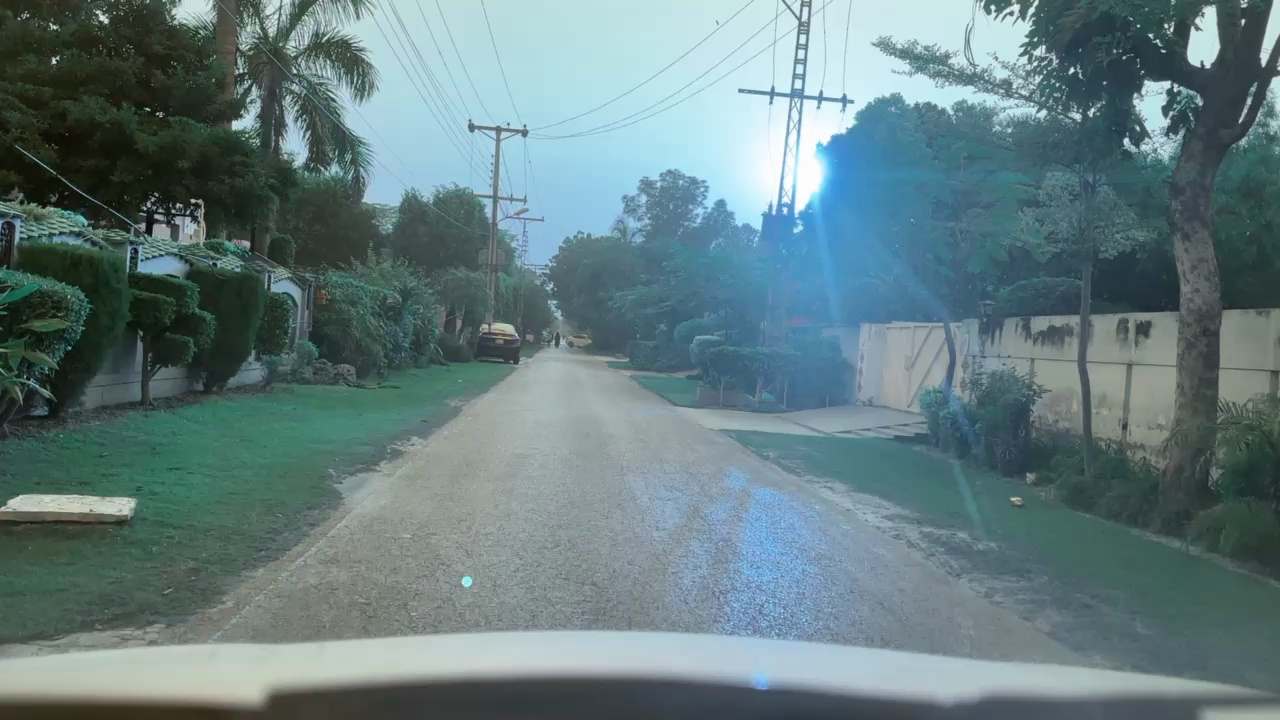


 Frame number: 1


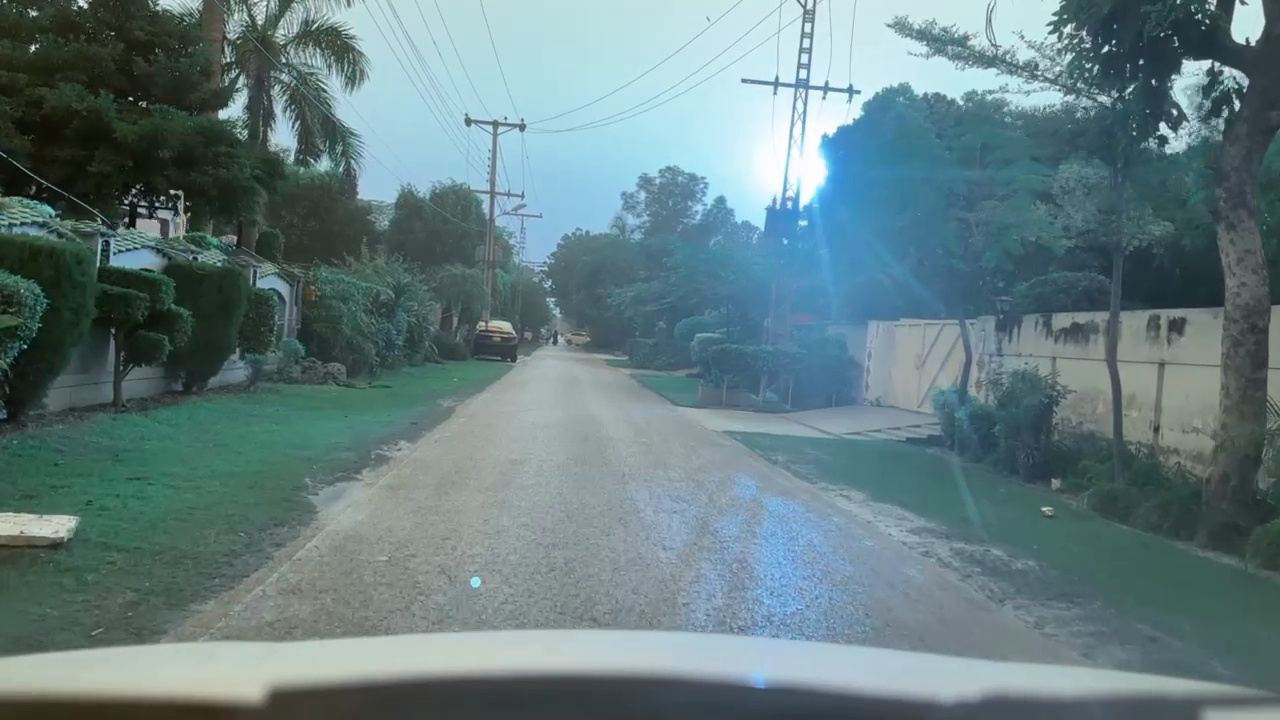


 Frame number: 2


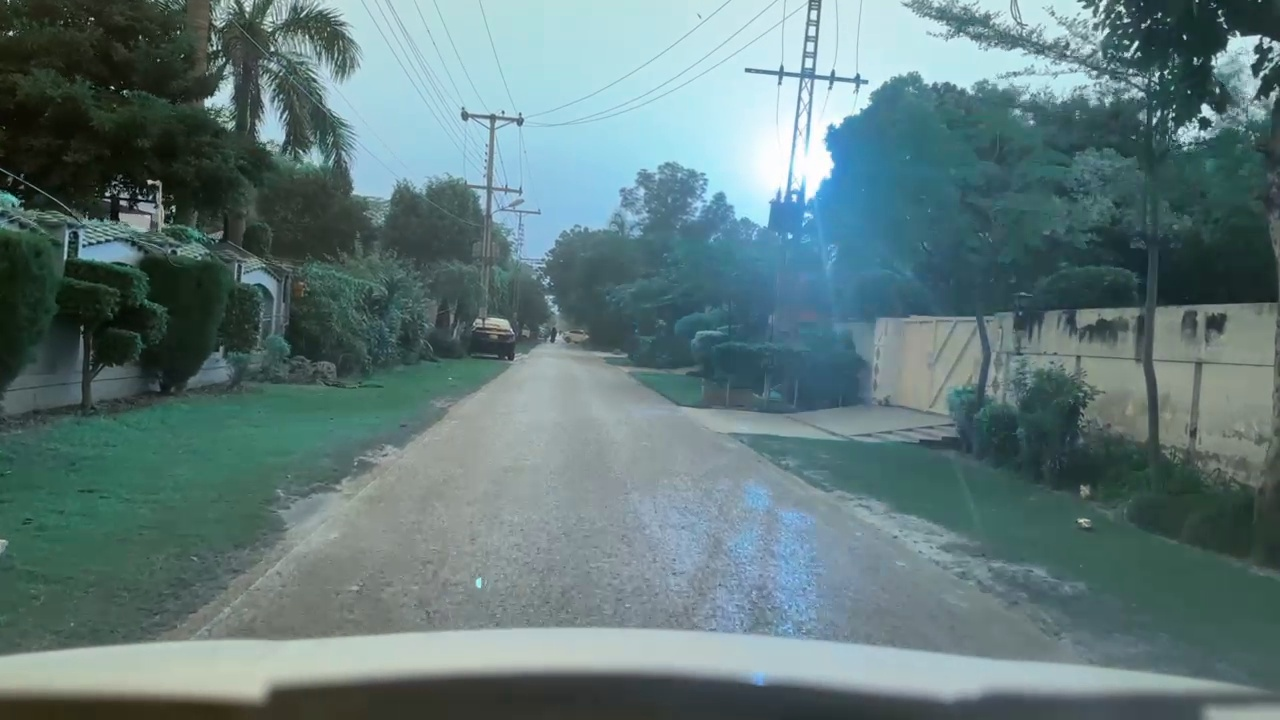


 Frame number: 3


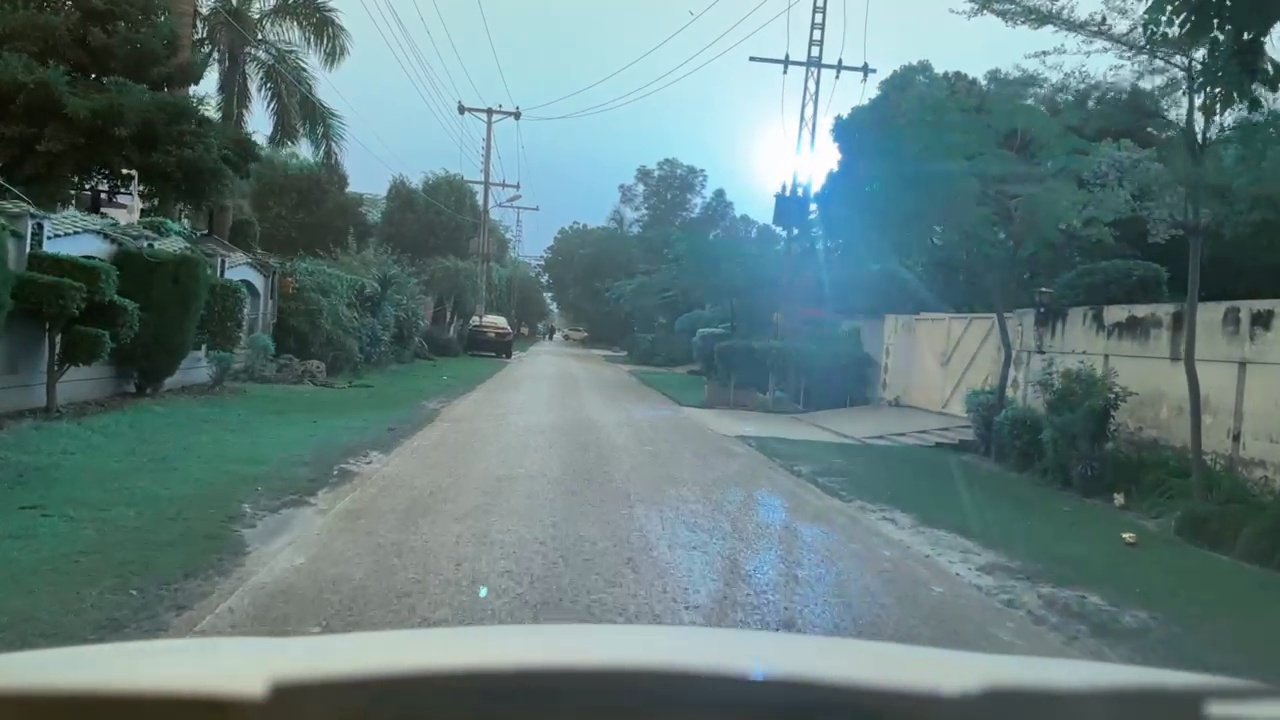


 Frame number: 4


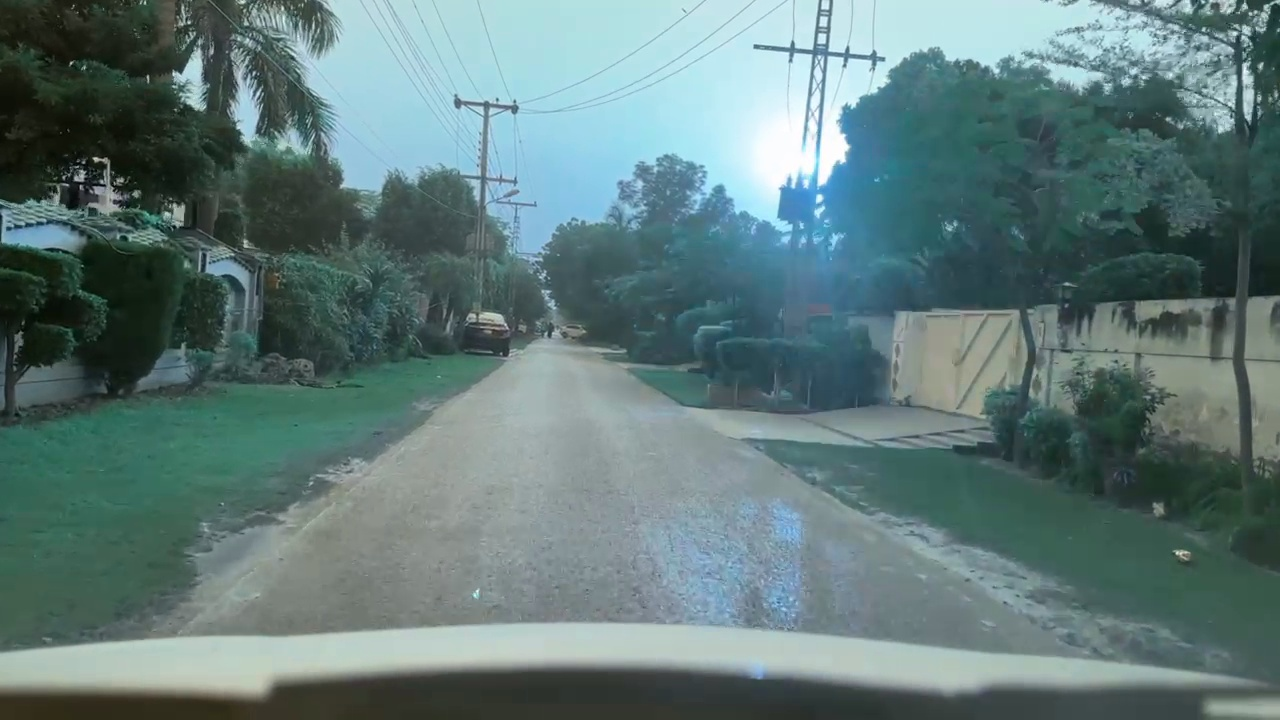

In [3]:
from IPython.display import display, Image

for i in range(5):
    # Convert BGR to RGB
    frame_rgb = cv2.cvtColor(frames[i], cv2.COLOR_BGR2RGB)
    print("\n Frame number:", i)
    # Display the image
    display(Image(data=cv2.imencode('.jpg', frame_rgb)[1]))


#Using Super Glue to attach the frames


In [6]:
%ls

 Volume in drive C is Windows-SSD
 Volume Serial Number is 84E9-F4A1

 Directory of c:\Users\khuze\OneDrive\Desktop\LUMS\Year 4\Fall 2023\CS 436\Project\Phase 3

26/11/2023  07:40 PM    <DIR>          .
26/11/2023  07:39 PM    <DIR>          ..
18/11/2023  09:29 PM        38,046,064 car_video.mp4
26/11/2023  07:42 PM         1,581,132 Phase3_rough.ipynb
               2 File(s)     39,627,196 bytes
               2 Dir(s)  302,023,856,128 bytes free


In [4]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
%config IPCompleter.greedy=True
%config Completer.use_jedi = False

In [6]:
# generating the necessary txt file to input for the super glue algorithm
img_name = 'frame' # set of outdoor images
num_images = len(frames)
# Order of the images. To stitch left and right images as depicted in the below
order = range(num_images -1,0,-1)
with open('adobe_panorama.txt', 'w') as file:
    for i in order:
        file.write("{img}-{:02}.png {img}-{:02}.png\n".format(i,i-1, img = img_name))

In [9]:
import cv2
import os

# Create the output folder if it doesn't exist
output_folder = 'adobe_panorama/'
os.makedirs(output_folder, exist_ok=True)

# Save each frame as a PNG file
for i, frame in enumerate(frames):
    # Construct the file name (you can adjust this based on your requirements)
    file_name = f"{output_folder}frame-{i}.png"

    # Save the frame as a PNG file
    cv2.imwrite(file_name, frame)

print(f"{len(frames)} frames saved to {output_folder}")

485 frames saved to adobe_panorama/


In [7]:
"""
    Do not resize the images,
    If you need to use the extracted keypoints,
    to process the "original" source images.

    Set the parameter to -1 to avoid resizing
    --resize -1

    Other parameter can be set as folows,
    to extract the best matching features.
    * Non maximum Suppression Radius = 5
    * Matching Confidence = 0.9
"""
!python match_pairs.py  --resize -1\
                        --superglue outdoor \
                        --max_keypoints 2048 \
                        --nms_radius 5 \
                        --resize_float \
                        --input_dir adobe_panorama/ \
                        --input_pairs adobe_panorama.txt \
                        --output_dir adobe_panorama/output \
                        --viz \
                        --keypoint_threshold 0.05 \
                        --match_threshold 0.9

Namespace(input_pairs='adobe_panorama.txt', input_dir='adobe_panorama/', output_dir='adobe_panorama/output', max_length=-1, resize=[-1], resize_float=True, superglue='outdoor', max_keypoints=2048, keypoint_threshold=0.05, nms_radius=5, sinkhorn_iterations=20, match_threshold=0.9, viz=True, eval=False, fast_viz=False, cache=False, show_keypoints=False, viz_extension='png', opencv_display=False, shuffle=False, force_cpu=False)
Will not resize images
Running inference on device "cpu"
Loaded SuperPoint model
Loaded SuperGlue model ("outdoor" weights)
Looking for data in directory "adobe_panorama"
Will write matches to directory "adobe_panorama\output"
Will write visualization images to directory "adobe_panorama\output"
[Finished pair     0 of   484] load_image=0.069 matcher=6.605 viz_match=0.900 total=7.574 sec {0.1 FPS} 
[Finished pair     1 of   484] load_image=0.067 matcher=6.352 viz_match=0.859 total=7.278 sec {0.1 FPS} 
[Finished pair     2 of   484] load_image=0.062 matcher=6.346 viz

c:\Users\khuze\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\functional.py:4236: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
[ WARN:0@3450.183] global loadsave.cpp:248 cv::findDecoder imread_('adobe_panorama\frame-09.png'): can't open/read file: check file path/integrity


In [7]:
#generatig the npz files for extract matching information
npz_files = ["{img}-{:02}_{img}-{:02}_matches.npz".format(i,i-1, img = img_name) for i in order]
for file in npz_files:
    path = 'adobe_panorama/output/'+file
    if path == 'adobe_panorama/output/frame-439_frame-438_matches.npz':
        break
    npz = np.load(path)
print(npz.files)

['keypoints0', 'keypoints1', 'matches', 'match_confidence']


In [8]:
def loadNPZ(npz_file):
    npz = np.load('adobe_panorama/output/'+ npz_file)
    point_set1 = npz['keypoints0'][npz['matches']>-1]
    matching_indexes =  npz['matches'][npz['matches']>-1] # -1 if the keypoint is unmatched
    point_set2 = npz['keypoints1'][matching_indexes]
    print("Number of matching points for the findHomography algorithm:")
    print("In left  image:", len(point_set1),"\nIn right image:", len(point_set2))
    return point_set1, point_set2

In [9]:
def pltSourceImages(imageSet):
    im_left = cv.imread('adobe_panorama/frames-{:02}.png'.format(imageSet),cv.IMREAD_ANYCOLOR)
    im_right = cv.imread('adobe_panorama/frames-{:02}.png'.format(imageSet -1),cv.IMREAD_ANYCOLOR)

    # Marking the detected features on the two images.
    for point in point_set1.astype(np.int32):
        cv.circle(im_left, tuple(point), radius=8, color=(255, 255, 0), thickness=-1)

    for point in point_set2.astype(np.int32):
        cv.circle(im_right, tuple(point), radius=8, color=(255, 255, 0), thickness=-1)

    fig = plt.figure(figsize = (10,10))
    plt.subplot(121),plt.imshow(im_left, cmap='gray', vmin = 0, vmax = 255)
    plt.subplot(122),plt.imshow(im_right, cmap='gray', vmin = 0, vmax = 255)
    plt.show()

In [10]:
def plotMatches(imageSet):
    plt.figure(figsize=(10,10))
    matched_points = cv.imread('adobe_panorama/output/hotel-{:02}_hotel-{:02}_matches.png'.\
                     format(imageSet, imageSet -1),cv.IMREAD_ANYCOLOR)
    plt.imshow(matched_points, cmap='gray', vmin = 0, vmax = 255)
    plt.show()

In [12]:
homographies = []
panoramas = []
for imgSet in range(num_images-1,1,-1):
    print("index", imgSet)
    # loading points
    if imgSet <= 10:
        break

    # pltSourceImages(imgSet)
    # plotMatches(imgSet)

    # getting the required source images
    im_left = cv.imread('adobe_panorama/frame-{:02}.png'.format(imgSet), cv.IMREAD_ANYCOLOR)
    im_right = cv.imread('adobe_panorama/frame-{:02}.png'.format(imgSet - 1), cv.IMREAD_ANYCOLOR)
    point_set1, point_set2 = loadNPZ(npz_files[num_images - 1 - imgSet])

    # Check the data type of the images
    print(f"Image {imgSet} data type: {type(im_left)}, Image {imgSet - 1} data type: {type(im_right)}")

    if im_left is None or im_right is None or not isinstance(im_left, np.ndarray) or not isinstance(im_right, np.ndarray):
        print(f"Failed to read one or both of the images for imgSet={imgSet}")
        continue

    #find Homography between two source images
    H, status = cv.findHomography(point_set1, point_set2, cv.RANSAC, 5.0)
    # Prints the Homography matrix that transform left image to right image

    homographies.append(H)
    # print(H)
    # Applies a homogeneous transformation to an image.
    # To transform the right image to left we need to consider the inverse.

    im_left = cv2.cvtColor(im_left, cv2.COLOR_BGR2GRAY) 
    im_right = cv2.cvtColor(im_right, cv2.COLOR_BGR2GRAY) 
    # Calculate the size of the output image (panorama)
    h1, w1 = im_left.shape[:2]
    h2, w2 = im_right.shape[:2]
    # Use cv2.warpPerspective to apply the homography to img1
    img1_warped = cv2.warpPerspective(im_left, H, (w1, h1 + h2))
    # Calculate the size of the panorama
    panorama_width = max(w1, w2)
    panorama_height = h1 + h2
    # Use cv2.warpPerspective to apply the inverse homography to img2
    img2_warped = cv2.warpPerspective(im_right, np.linalg.inv(H), (w2, h2))
    panorama = np.zeros((panorama_height, panorama_width), dtype=np.uint8)
    # Copy the top part of the warped first image to the panorama
    panorama[:h1, :w1] = img1_warped[:h1, :]
    # Copy the bottom part of the second image to the panorama
    panorama[h1:h1+h2, :w2] = img1_warped[h1:, :]

    panoramas.append(panorama)
    
    # plt.figure(figsize=(10,10))
    # plt.imshow(panorama, cmap='gray', vmin = 0, vmax = 255)
    # panorama[0:im_left.shape[0], 0:im_left.shape[1]] = im_left
    # plt.figure(figsize=(10,10))
    # plt.imshow(panorama, cmap='gray', vmin = 0, vmax = 255)
    # plt.show()
    # print("-"*100)

index 484
Number of matching points for the findHomography algorithm:
In left  image: 601 
In right image: 601
Image 484 data type: <class 'numpy.ndarray'>, Image 483 data type: <class 'numpy.ndarray'>
index 483
Number of matching points for the findHomography algorithm:
In left  image: 632 
In right image: 632
Image 483 data type: <class 'numpy.ndarray'>, Image 482 data type: <class 'numpy.ndarray'>
index 482
Number of matching points for the findHomography algorithm:
In left  image: 647 
In right image: 647
Image 482 data type: <class 'numpy.ndarray'>, Image 481 data type: <class 'numpy.ndarray'>
index 481
Number of matching points for the findHomography algorithm:
In left  image: 716 
In right image: 716
Image 481 data type: <class 'numpy.ndarray'>, Image 480 data type: <class 'numpy.ndarray'>
index 480
Number of matching points for the findHomography algorithm:
In left  image: 594 
In right image: 594
Image 480 data type: <class 'numpy.ndarray'>, Image 479 data type: <class 'numpy.

Using the homography matrix we got for Task 2

In [13]:
first_frame_top_down_H =  [[-1.22521694e-04,  9.42912528e-04, -3.69150747e-01],
                            [-5.02131563e-04,  2.32199103e-03, -9.29365832e-01],
                            [-5.53416550e-07,  1.83413284e-06, -5.73390455e-04]]

first_frame_top_down_H = np.array(first_frame_top_down_H)

In [14]:
print(len(homographies))
num_img_new = len(homographies)

474


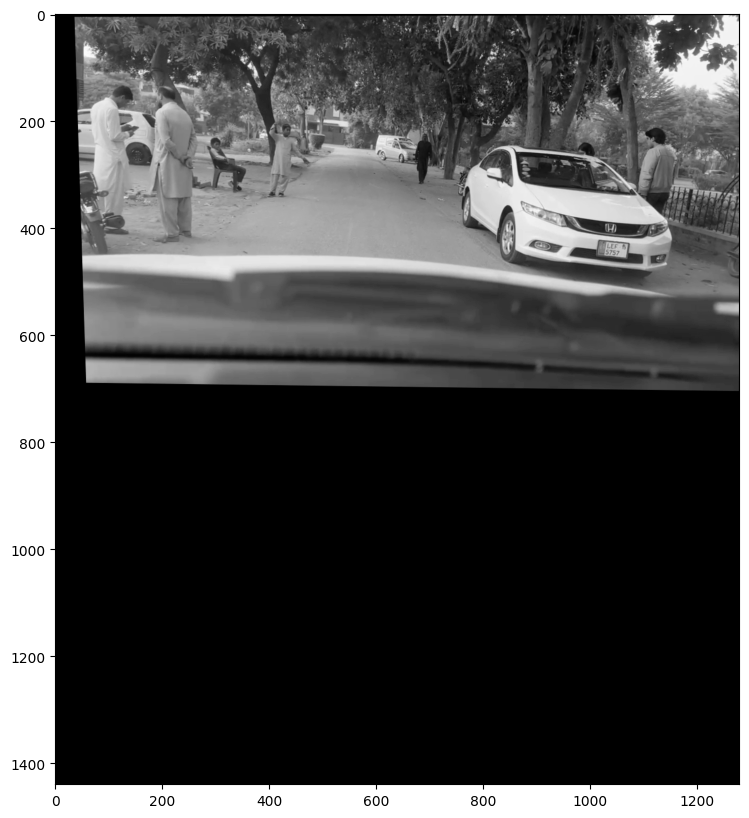

(1440, 1280)


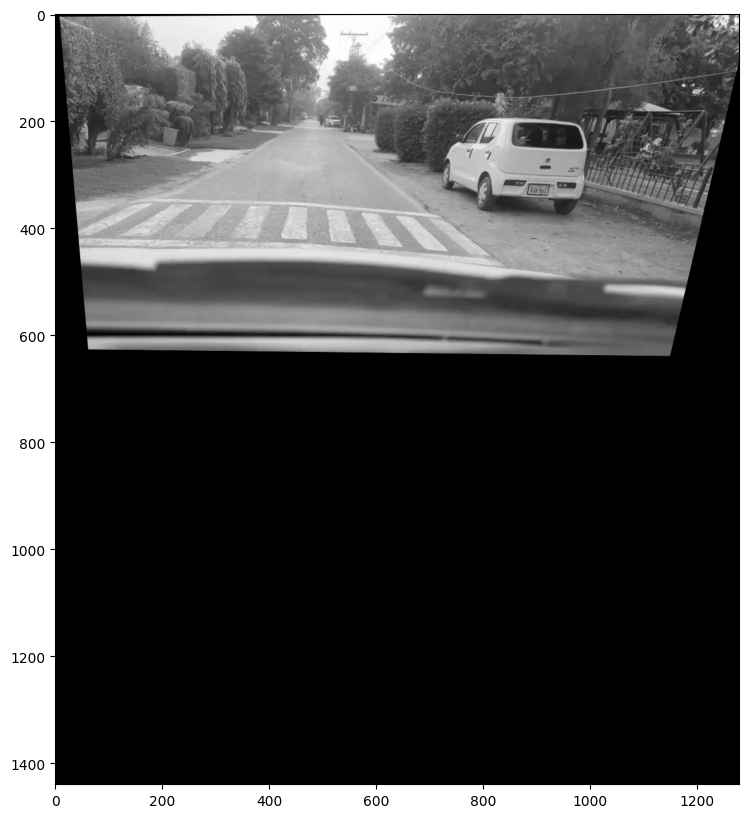

(1440, 1280)


In [23]:
plt.figure(figsize=(10,10))
plt.imshow(panoramas[0], cmap='gray', vmin = 0, vmax = 255)
plt.show()
print(panoramas[0].shape)

plt.figure(figsize=(10,10))
plt.imshow(panoramas[100], cmap='gray', vmin = 0, vmax = 255)
plt.show()
print(panoramas[100].shape)

In [27]:
last_img  = cv2.imread('adobe_panorama/frame-{:02}.png'.format(len(frames) -1),cv.COLOR_BGR2GRAY)
last_img = cv2.cvtColor(last_img, cv2.COLOR_BGR2GRAY) 
last_img = cv2.resize(last_img,(1500,800))


for i in range(0,num_img_new):
    print(last_img.shape)
    print(homographies[i])

    im_left = last_img
    im_right = frames[num_img_new - i - 1]
    # Calculate the size of the output image (panorama)
    h1, w1 = im_left.shape[:2]
    h2, w2 = im_right.shape[:2]
    # Use cv2.warpPerspective to apply the homography to img1
    img1_warped = cv2.warpPerspective(im_left, H, (w1, h1 + h2))
    # Calculate the size of the panorama
    panorama_width = max(w1, w2)
    panorama_height = h1 + h2
    # Use cv2.warpPerspective to apply the inverse homography to img2
    img2_warped = cv2.warpPerspective(im_right, np.linalg.inv(H), (w2, h2))
    panorama = np.zeros((panorama_height, panorama_width), dtype=np.uint8)
    # Copy the top part of the warped first image to the panorama
    panorama[:h1, :w1] = img1_warped[:h1, :]
    # Copy the bottom part of the second image to the panorama
    panorama[h1:h1+h2, :w2] = img1_warped[h1:, :]

    # temp = cv2.warpPerspective(last_img,  np.linalg.inv(homographies[i]), (1500,800))

    plt.figure(figsize=(10,10))
    plt.imshow(temp, cmap='gray', vmin = 0, vmax = 255)
    plt.show()
    last_img = temp

(800, 1500)
[[ 9.56583077e-01  3.29534812e-02  3.64472488e+01]
 [-3.14388190e-03  9.82397426e-01  5.41754907e+00]
 [-2.22414829e-05  4.66676617e-05  1.00000000e+00]]


ValueError: could not broadcast input array from shape (720,1500) into shape (720,1280)

In [98]:
print(last_img)
last_frame_top_view =  cv2.warpPerspective(last_img,  np.linalg.inv(first_frame_top_down_H), (1500,800)) 
print(last_frame_top_view)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


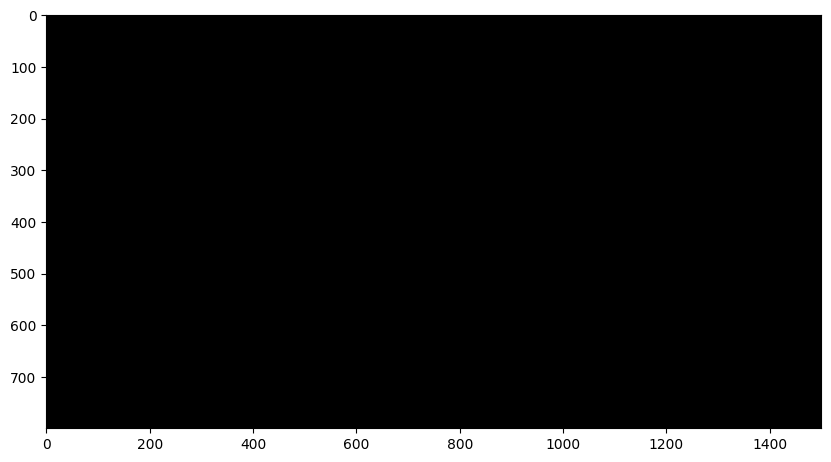

In [99]:
plt.figure(figsize=(10,10))
plt.imshow(last_frame_top_view, cmap='gray', vmin = 0, vmax = 255)
plt.show()

In [ ]:
new_h_array = []
cumulative = homographies[0]

for i in range(len(homographies)):
    temp = np.matmul(homographies[i], cumulative)
    new_h_array.append(temp)
    cumulative = temp

